In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.ion()

import os
import sys
import re
import pdb
import glob

num_possible_ss = 2*4**7

In [2]:
RESULT_FILE_PATTERN = re.compile('../from_pipeline/results\.(?P<base>.*)\.txt')
BASE_PATTERN = re.compile('(?P<locus>.+)_lib(?P<lib_num>[0-9]+)_rep(?P<rep_num>[0-9]+)')

class Result:
    ''' Class to hold information on a results file'''
    def __init__(self,file_name):
        self.valid=False
        m = re.match(RESULT_FILE_PATTERN,file_name)
        if m:
            self.data_file = file_name
            
            d1 = m.groupdict()
            self.base = d1['base']
            self.report_file = '../from_pipeline/report.results.%s.txt'%(self.base)
            
            d2 = re.match(BASE_PATTERN,self.base).groupdict()
            self.locus = d2['locus']
            self.lib_num = int(d2['lib_num'])
            self.rep_num = int(d2['rep_num'])
            self.valid=True

            # Read in data
            assert os.path.isfile(self.data_file)
            self.data_df = pd.read_csv(self.data_file,delim_whitespace=True)
            
            # Load report file
            assert os.path.isfile(self.report_file)
            with open(self.report_file) as f:
                self.report = f.read()

        
    def __repr__(self):
        return '%s_lib%d_rep%d'%(self.locus,self.lib_num,self.rep_num)

In [3]:
results_dict = {}
file_names = glob.glob('../from_pipeline/results.*.txt')
for file_name in file_names:
    result = Result(file_name)
    if result.valid:
        name = repr(result)
        results_dict[name] = result
        print name

brca2_11nt_lib1_rep2
ikbkap_9nt_lib2_rep1
brca2_11nt_lib1_rep3
brca2_11nt_lib1_rep1
ikbkap_9nt_lib2_rep2
ikbkap_9nt_lib2_rep3
brca2_9nt_lib2_rep3
brca2_9nt_lib2_rep2
smn1_9nt_lib1_rep1
smn1_9nt_lib1_rep3
brca2_9nt_lib2_rep1
smn1_9nt_lib1_rep2
brca2_11nt_lib2_rep1
ikbkap_9nt_lib1_rep2
brca2_11nt_lib3_rep1
ikbkap_9nt_lib1_rep3
brca2_11nt_lib3_rep2
brca2_11nt_lib2_rep2
ikbkap_9nt_lib1_rep1
brca2_11nt_lib2_rep3
brca2_11nt_lib3_rep3
smn1_9nt_lib2_rep3
smn1_9nt_lib3_rep3
brca2_9nt_lib1_rep1
smn1_9nt_lib3_rep2
smn1_9nt_lib2_rep2
brca2_9nt_lib1_rep3
brca2_9nt_lib1_rep2
smn1_9nt_lib2_rep1
smn1_9nt_lib3_rep1


In [8]:
df = results_dict['brca2_9nt_lib1_rep2'].data_df.copy()

In [9]:
# Filter barcodes to only include those with tot_ct > 10
df = pd.read_csv('../from_pipeline/results.brca2_9nt_lib1_rep2.txt', delim_whitespace=True)
df = df[df['tot_ct'] > 10]
df['ratio'] = df['ex_ct']/df['tot_ct']
df.head()

,tot_ct,ex_ct,lib_ct,mis_ct,ss,bc,ratio
0,404,4470,87,1,CAGGTTAGA,ACCGATCTGCCACGGCGACC,11.064356
1,380,33,164,3,ACAGCGGGA,TTAGCTATCGGCTGACGTCT,0.086842
2,341,22,109,2,CAAGCCTTA,AGGGACCATCCAGTTCGCCT,0.064516
3,312,16,97,1,AGCGTGTAT,CCACCCAACGCGCCGTCAGT,0.051282
4,295,4405,46,1,CAGGTGAGA,TTGAGGTACACTGAACAGTC,14.932203


In [10]:
cons_df = df[df['ss'] == 'CAGGTAAGT']
cons_ratio = cons_df['ex_ct'].sum() / cons_df['tot_ct'].sum()
print cons_ratio

14.6933962264


In [11]:
num_bc_per_ss = df.groupby('ss').size()
num_bc_per_ss.sort(inplace=True,ascending=False)
num_bc_per_ss.head()

/Users/jkinney/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  from ipykernel import kernelapp as app


ss
ACAGCGGTA    43
AACGCCAGG    35
ACGGCTTGG    33
ACGGTCCAT    33
AAAGCCAGG    33
dtype: int64

In [12]:
median_ratios = df[['ss','ratio']].groupby('ss').median().sort('ratio',ascending=False)
median_ratios['num_bc'] = df.groupby('ss').size()
median_ratios['psi'] = 100*median_ratios['ratio'] / cons_ratio
median_ratios.head()

/Users/jkinney/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,ratio,num_bc,psi
ss,,,
CGGGTAACC,29.307692,1,199.461662
CCAGTCGGC,24.916667,1,169.577314
CCGGTAAAG,24.608392,2,167.479262
GCGGTAAGG,22.958333,4,156.249331
GGCGTAAGT,21.579923,4,146.868178


In [13]:
# Filter splice sites to include only those with
# median PSI > 20 and num_bc > 10
indices = (median_ratios['psi'] > 20) & (median_ratios['num_bc'] > 10)
print sum(indices)
all_ss_to_keep = median_ratios.index[indices]
ss_to_keep = np.random.choice(all_ss_to_keep, 20, replace=False)
tmp_df = df[df['ss'].isin(ss_to_keep)]
tmp_df['psi'] = 100 * tmp_df['ratio'] / cons_ratio
tmp_df.reset_index(inplace=True)
tmp_df.head()

303


/Users/jkinney/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,index,tot_ct,ex_ct,lib_ct,mis_ct,ss,bc,ratio,psi
0,219,141,1405,28,0,ATGGTGGGT,CATATCGCCAAGCTGGAGTT,9.964539,67.816445
1,475,120,1453,90,1,AAGGTAATA,TACGATCCTTAGTGCTCGTA,12.108333,82.406635
2,634,113,1434,45,2,CCGGTTAGT,CTTGAATCTGTCACTGGCTT,12.690265,86.367136
3,658,112,1125,58,1,ATGGTGAGG,TCACCTTCGCTGCGTTTGAG,10.044643,68.361614
4,753,109,1778,92,4,CAGGTATTA,ATTTCAGTCAACGCATGAAT,16.311927,111.015359


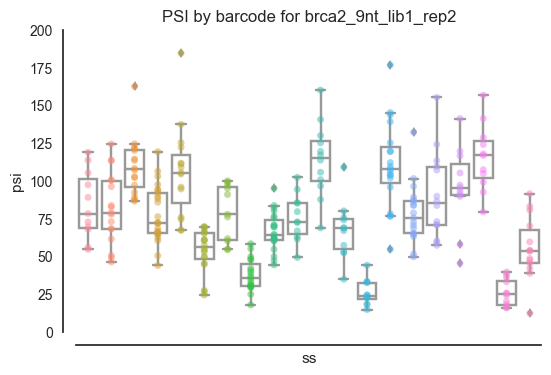

In [14]:
sns.set_style('white')
sns.boxplot(x='ss', y='psi', data=tmp_df, color='white')
sns.stripplot(x='ss', y='psi', data=tmp_df, alpha=.5)
plt.ylim([0,200])
plt.xticks([])
sns.despine(offset=10, trim=True);
plt.title('PSI by barcode for brca2_9nt_lib1_rep2')
plt.savefig('../plots/barcode.brca2_9nt_lib1_rep2.pdf')

In [ ]:
# Turn this into a script!